In [2]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt


In [3]:
#%%

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]

# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]

# %%

# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 
#shape[(24, 4794, 1) (24, 4794, 1) (4794, 5) (24, 4794, 1)]

In [4]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 32, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

In [5]:
# Select the first 20 time series from the original 'time_series_1_sun' data
time_series_1 = time_series_1_sun[0:20, :, :]

# Concatenate the selected time series with the existing 'time_series_1_sun_average' data along the first dimension
# This effectively adds the new 20 time series to the existing dataset
time_series_1_sun_average = np.concatenate((time_series_1, time_series_1_sun_average), axis=0)

# Select the first 20 samples from the original 'outdoor_panels_power' data
outdoor_panel_power_1 = outdoor_panels_power[0:20, :, :]

# Concatenate the selected outdoor panel power data with the existing 'outdoor_panels_power_average' data
# This adds the new 20 samples to the existing dataset
outdoor_panels_power_average = np.concatenate((outdoor_panel_power_1, outdoor_panels_power_average), axis=0)





(32, 4794, 1)


In [6]:
# Compute the moving average for each panel's time series using the specified window size
window_size = 30
time_series_1_sun_average_ma = np.zeros((32, 4794, 1))
for panel in range(32):
    for point in range(4794):
        if point < window_size-1:
            # If there are not enough previous points, use the current value
            time_series_1_sun_average_ma[panel, point] = time_series_1_sun_average[panel, point]
        else:
            # Compute the moving average using the previous window_size points
            average = np.mean(time_series_1_sun_average[panel, point-window_size+1:point+1])
            time_series_1_sun_average_ma[panel, point] = average

# Compute the global difference for each panel's time series
time_series_1_sun_average_global_diff = np.zeros((32, 4794, 1))
for panel in range(32):
    global_mean = np.mean(time_series_1_sun_average[panel])
    time_series_1_sun_average_global_diff[panel] = time_series_1_sun_average[panel] - global_mean

# Compute Exponential Moving Average (EMA) for each panel's time series using the specified window size
window_size = 10
ema_values = np.zeros((32, 4794, 1))
for panel_idx in range(ema_values.shape[0]):
    panel_data = pd.Series(time_series_1_sun_average[panel_idx, :, 0])
    ema = panel_data.ewm(span=window_size).mean()
    ema_values[panel_idx, :, 0] = ema.values

# Compute the Fourier Transform of each panel's time series
fourier_transform = np.fft.fft(time_series_1_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_1_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)

# Concatenate all the new features along with outdoor conditions to create the final feature set
all_new_features = np.concatenate((time_series_1_sun_average, time_series_1_sun_average_ma, 
                                   time_series_1_sun_average_global_diff, outdoor_conditions_stacked), axis=2)

# Print the shape of the final feature set and the shape of outdoor_panels_power_average
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(32, 4794, 8)
(32, 4794, 1)


In [7]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [8]:
# Convert and transfer training data to the selected device
all_new_features_train=all_new_features[0:30, :, :].astype(np.float32)
all_new_features_train= torch.from_numpy(all_new_features_train).float().to(device)
target = torch.from_numpy(outdoor_panels_power_average[0:30, :, :]).float().to(device)


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True))
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True))

        # Define fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 32)  # Fully connected layer 2
        self.fc3 = nn.Linear(32, output_dim)  # Fully connected layer 3
        self.leaky_relu = nn.LeakyReLU(0.001)
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight)
            if m.bias is not None:
                # Initialize the bias with a random number between 0 and 1
                init.constant_(m.bias, 0)
          elif isinstance(m, nn.LSTM):
              for name, param in m.named_parameters():
                 if 'weight' in name:
                   init.kaiming_normal_(param)
                 elif 'bias' in name:
                    # Initialize the bias with a random number between 0 and 1
                    init.constant_(param, 0)
    def silu(self, x):
        return x * torch.sigmoid(x)
    def forward(self, x):
        # Iterate through LSTM layers
        for i in range(self.num_layers):
            if i == 0:
                lstm_output, _ = self.lstm_layers[i](x)  # Apply the first LSTM layer
            else:
                lstm_output, _ = self.lstm_layers[i](lstm_output)  # Apply subsequent LSTM layers
        
        # Apply fully connected layers
        output = self.fc1(lstm_output)  # Apply fully connected layer 1
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc2(output)  # Apply fully connected layer 2
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc3(output)  # Apply fully connected layer 3
        
        return output




 







Mean Squared Error (MSE): 2.494513988494873


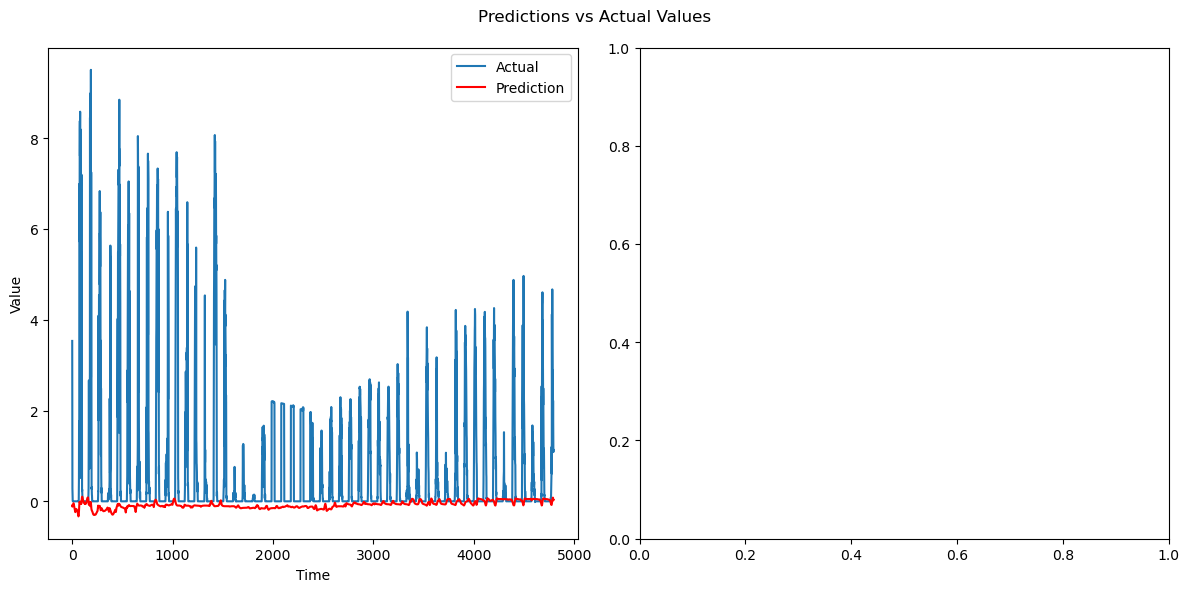

In [10]:
# Set the hyperparameters for the model and training
input_dim = 8  # Number of features in the outdoor conditions and the indoor measurements
hidden_dim = 128
output_dim = 1  # The number of features in the output
num_epochs = 0  # Number of epochs for training (no training in this case)
num_layers = 4
num_mixtures = 5
learning_rate = 0.001
weight_decay = 0.1
Fold = 0

# Create arrays to store predictions and test target for each fold
Predictions = np.zeros((6, 4794, 1))
Test = np.zeros((6, 4794, 1))

# Initialize KFold cross-validation
kf = KFold(n_splits=30)

# Create the LSTM model, loss criterion, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Loop through each fold in the cross-validation
for train_index, test_index in kf.split(all_new_features_train):
    # Separate training and test data for the current fold
    train_input = all_new_features_train[train_index]
    train_target = target[train_index]
    test_input = all_new_features_train[test_index]
    test_target = target[test_index]
    
    # No training is performed (num_epochs = 0), as specified
    
    # Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        sample_input = test_input
        predictions = model(sample_input)
        Predictions[Fold] = predictions.numpy()
        Test[Fold] = test_target.numpy()
        mse = F.mse_loss(predictions, test_target)
        print("Mean Squared Error (MSE):", mse.item())

    # Plotting the predictions against the actual values for the first fold
    if Fold == 0:
        x = range(test_target.shape[1])
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        for i, axs in enumerate(axs.flat):
            axs.plot(x, test_target[i].flatten(), label='Actual')
            axs.plot(x, predictions[i].flatten(), label='Prediction', color='red')
            axs.set_xlabel('Time')
            axs.set_ylabel('Value')
            axs.legend()
            break
        fig.suptitle('Predictions vs Actual Values')
        plt.tight_layout()
        plt.show()

    Fold += 1
    if Fold == 1:
        break


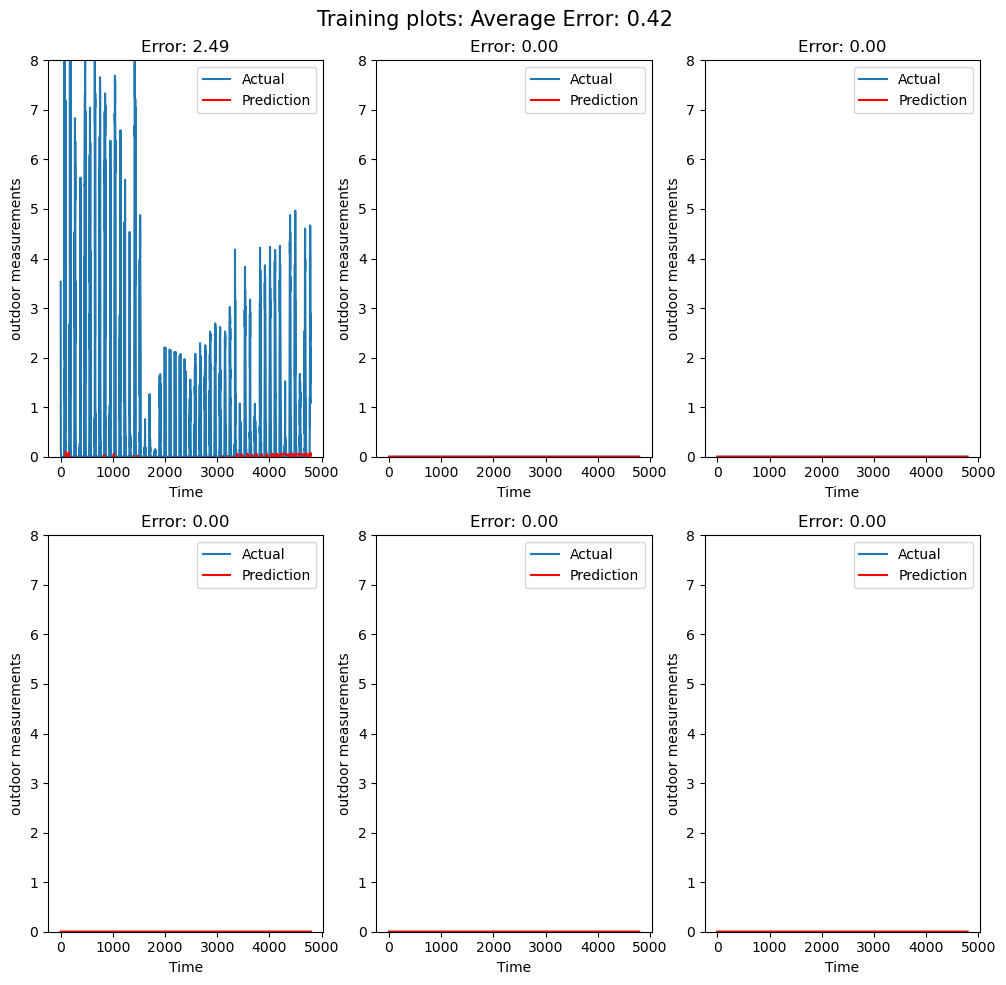

In [11]:
# Plot the predictions from the training set
x = range(Predictions.shape[1])
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
mse_scores = []

# Iterate over each panel's predictions
for i, axs in enumerate(axs.flat):
    # Plot the actual values and predictions for the current panel
    axs.plot(x, Test[i], label='Actual')
    axs.plot(x, Predictions[i], label='Prediction', color='red')
    axs.set_xlabel('Time')
    axs.set_ylabel('outdoor measurements')
    axs.legend()
    axs.set_ylim(0, 8)
    
    # Calculate the Mean Squared Error (MSE) for the current panel's predictions
    mse = F.mse_loss(torch.tensor(Predictions[i]), torch.tensor(Test[i]))
    mse_scores.append(mse.item())
    
    # Set the title for the current panel's plot with the calculated MSE
    axs.set_title(f'Error: {mse.item():.2f}')

# Calculate the average MSE error for all panels
average_error = np.mean(mse_scores)

# Set the figure title with the average MSE error
fig.suptitle(f'Training plots: Average MSE Error: {average_error:.2f}', fontsize=15)

# Save the plot as "training.pdf" in the current working directory
plt.savefig('training.pdf')

# Ensure the plots are displayed neatly without overlapping
plt.tight_layout()

# Show the plot
plt.show()

Average MSE Error: 4.6696


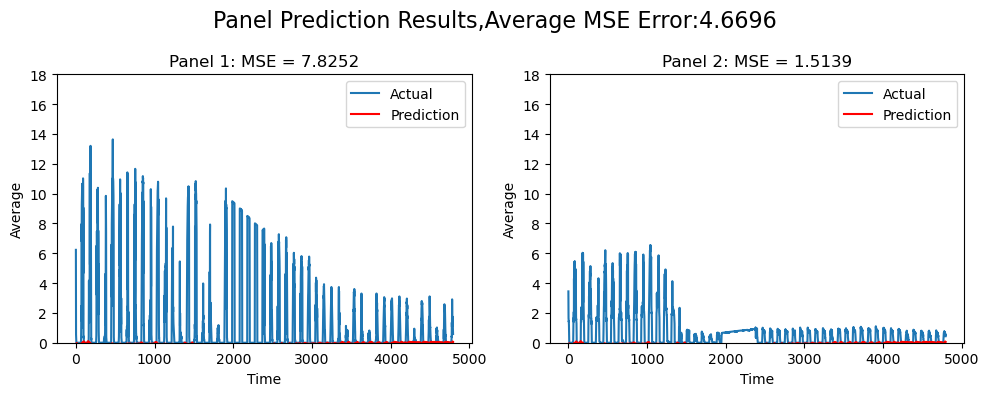

In [18]:
# Evaluate the model and plot the predictions from the test set
all_new_features_test = all_new_features[30:32, :, :].astype(np.float32)
outdoor_panels_power_0 = outdoor_panels_power_average[30:32].astype(float)
model.eval()
loss = []
outdoor_panels_power_t0 = torch.from_numpy(outdoor_panels_power_0).to(device)
all_new_features_test_0 = torch.from_numpy(all_new_features_test).float().to(device)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Add a title to the entire figure
fig.suptitle("Panel Prediction Results", fontsize=16)

# Iterate over the two panels for predictions
for i, ax in enumerate(axs.flat):
    with torch.no_grad():
        # Get the input and target sequences for the current panel
        train_in = all_new_features_test_0[i:i + 1, :, :]
        target_test = outdoor_panels_power_t0[i:i + 1, :, :]
        
        # Make predictions for the current panel
        pred = model(train_in)
        
        # Calculate the Mean Squared Error (MSE) for the current panel's predictions
        mse = F.mse_loss(pred[0], outdoor_panels_power_t0[i])
        loss.append(mse.item())
        
        # Set the x-axis values
        x = range(target_test.shape[1])
        
        # Plot the actual values and predictions for the current panel
        ax.plot(x, target_test[0], label='Actual')
        ax.plot(x, pred[0], label='Prediction', color='red')
        
        # Set the title for the current subplot with the calculated MSE
        ax.set_title("Panel {}: MSE = {:.4f}".format(i + 1, mse.item()))
        ax.set_xlabel('Time')
        ax.set_ylabel('Average')
        ax.legend()
        ax.set_ylim([0, 18])

# Ensure the plots are displayed neatly without overlapping
plt.tight_layout()

# Calculate the average of the MSE errors
mean_mse = np.mean(loss)
print("Average MSE Error: {:.4f}".format(mean_mse))
fig.suptitle("Panel Prediction Results,Average MSE Error:{:.4f}".format(mean_mse), fontsize=16)
# Show the plot
plt.show()
